In [ ]:
import re
import numpy as np
import pandas as pd

# visualization
import missingno as msno # missing value check
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier


# evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings(action='ignore') 

In [2]:
import os
file_list = []
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        file_list.append(os.path.join(dirname, filename))
file_list

['./data/train.csv',
 './data/test.csv',
 './data/sample_submission.csv',
 './data/test_labels.csv']

In [3]:
# load data
train = pd.read_csv('/data/private/competition/data/train.csv')
test = pd.read_csv('/data/private/competition/data/test.csv')

# submission example
submission = pd.read_csv('/data/private/competition/data/sample_submission.csv')
test_labels = pd.read_csv('/data/private/competition/data/test_labels.csv')

In [4]:
print("train data length: ", len(train))
print("test data length: ", len(test))

train data length:  159571
test data length:  153164


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [6]:
train.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [7]:
target_cols = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']

In [8]:
# Check missing value
print(train.isnull().value_counts())
print('-'*30)
print(train.isnull().sum())

id     comment_text  toxic  severe_toxic  obscene  threat  insult  identity_hate
False  False         False  False         False    False   False   False            159571
dtype: int64
------------------------------
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


<AxesSubplot:>

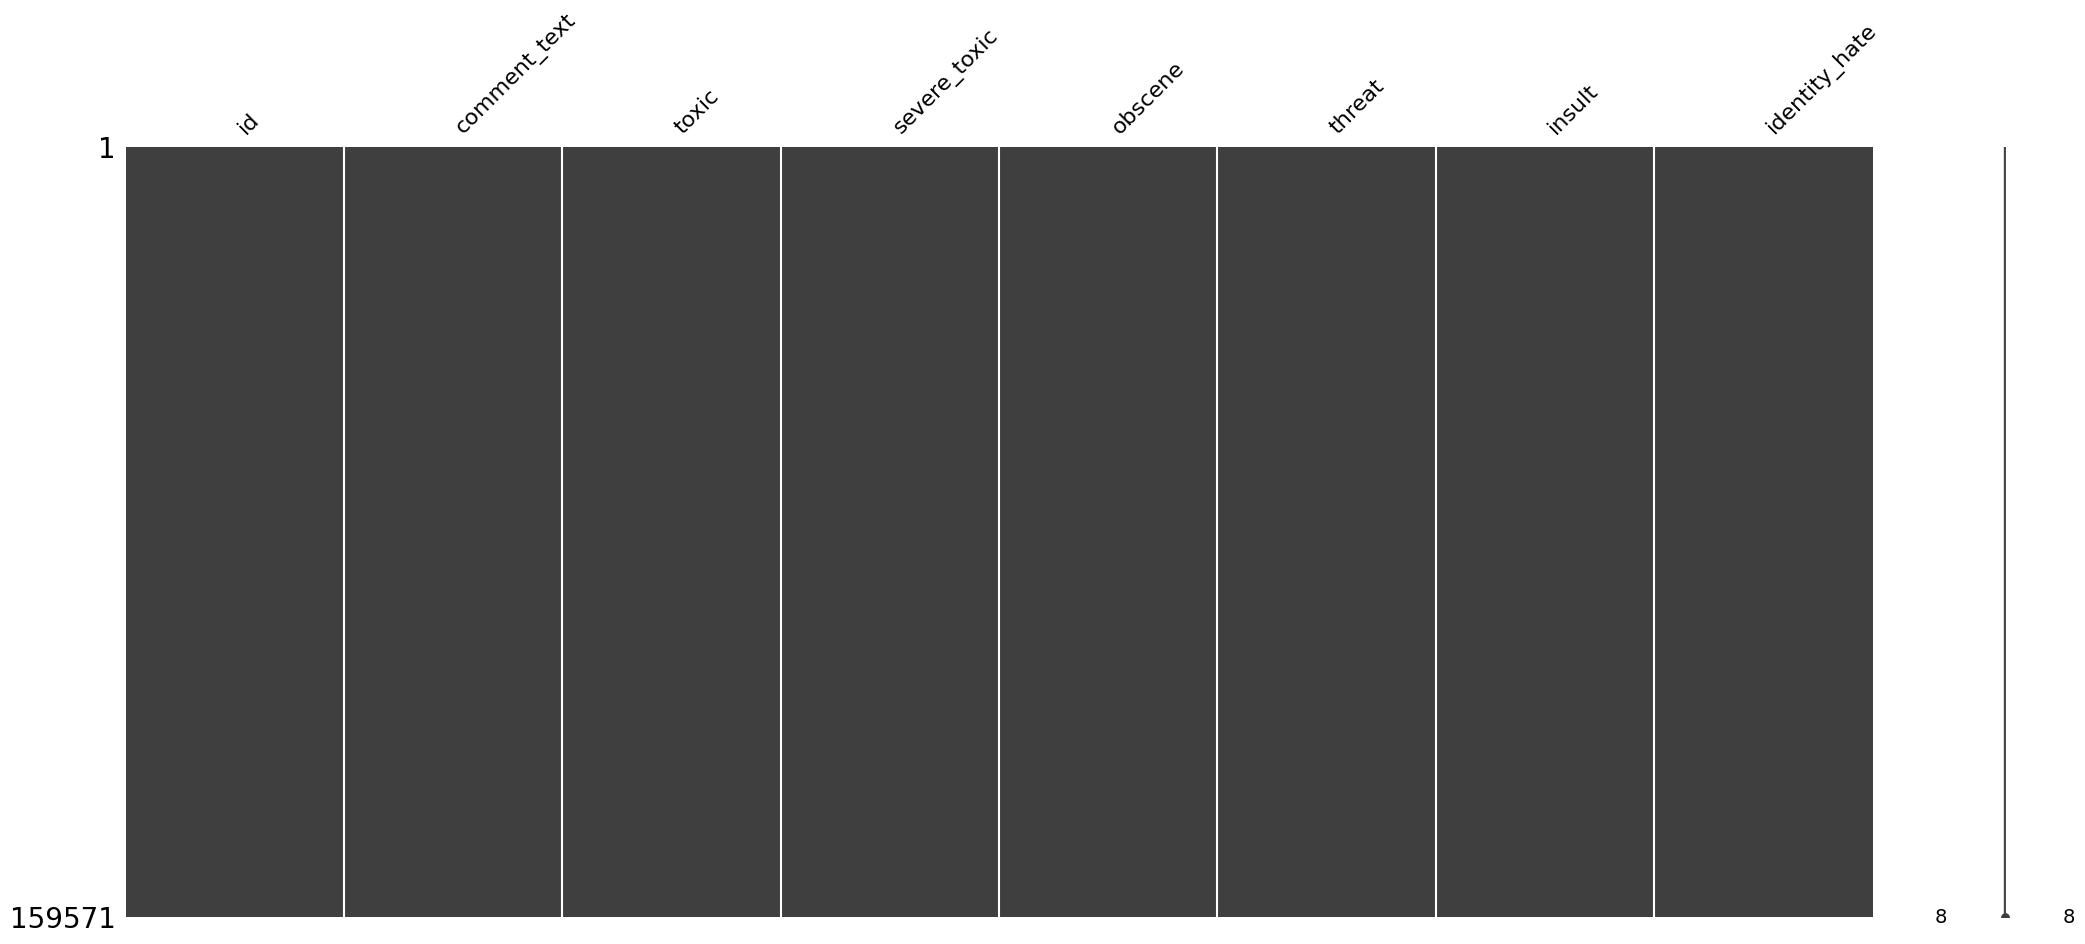

In [9]:
# data size
print('size of train : {}'.format(len(train)))
print('size of test : {}'.format(len(test)))
print('-'*20)
print(train[target_cols].sum().sort_values(ascending=False))

# Preprocess

In [10]:
target_cols

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [11]:
train['sum_harmful'] = 0
for col in target_cols:
    train['sum_harmful'] += train[col]
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_harmful
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


In [12]:
train['len_of_text'] = train['comment_text'].apply(len)

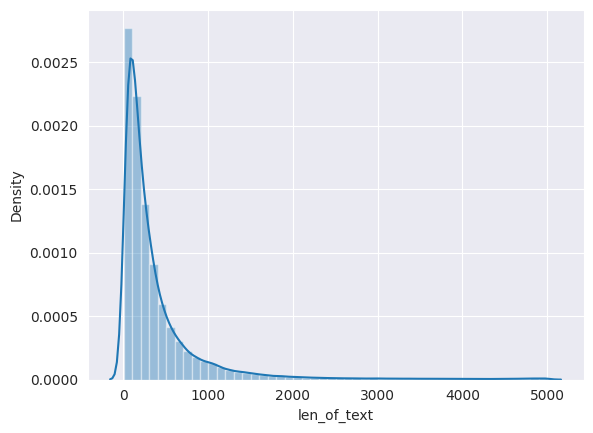

In [13]:
sns.set_style("darkgrid")
sns.distplot(train['len_of_text'],kde=True)
plt.show()

### 1. 텍스트 전처리 - 줄임말 바꾸기

In [14]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [16]:
train['preprocess_text'] = train['comment_text'].apply(clean_text)

### 2. 텍스트 전처리 - 불용어 제거
- 불용어 리스트 만들기 
- 불용어 제거 

In [17]:
# 전체 데이터에 대해 Countvectorizer
cv = CountVectorizer() # 만약 n-gram으로 설정시 안에 (2-gram까지하는 경우)ngram_range = (1, 3) 를 설정
documents = train.comment_text.tolist()
documents = [' '.join(documents)] 

X = cv.fit_transform(documents).toarray()
freqs = X.transpose().flatten() # 1차원으로, 어레이로 되어있는 인코딩 벡터들을 1차원으로 펴줌
words = cv.get_feature_names() # Array mapping from feature integer indices to feature name.

df_word = pd.DataFrame({'word': words, 'freq': freqs})
df_word = df_word.sort_values(by='freq', ascending=False)

df_word = df_word.reset_index().drop(['index'],axis=1)
df_word[:10]

,word,freq
0,the,496796
1,to,297408
2,of,224547
3,and,224092
4,you,218308
5,is,176405
6,that,160867
7,it,148644
8,in,145477
9,for,102723


In [22]:
stopwords_list = df_word.word.tolist()[:70]
print('데이터로 만든 불용어 개수 : ',len(stopwords_list))
print(stopwords_list)

from nltk.corpus import stopwords
stopwords_list+=stopwords.words('english')
stopwords = set(stopwords_list)
print(len(stopwords))

데이터로 만든 불용어 개수 :  70
['the', 'to', 'of', 'and', 'you', 'is', 'that', 'it', 'in', 'for', 'this', 'not', 'on', 'be', 'as', 'have', 'are', 'your', 'with', 'if', 'article', 'was', 'or', 'but', 'wikipedia', 'page', 'my', 'an', 'from', 'by', 'do', 'can', 'at', 'me', 'about', 'talk', 'so', 'what', 'there', 'all', 'has', 'will', 'please', 'no', 'would', 'they', 'he', 'one', 'like', 'just', 'we', 'which', 'any', 'been', 'should', 'don', 'more', 'some', 'other', 'here', 'who', 'see', 'also', 'his', 'think', 'because', 'know', 'how', 'people', 'am']
192


In [ ]:
from wordcloud import WordCloud
cloud = WordCloud(width=800, height=600).generate(" ".join(train['comment_text']))
plt.figure(figsize=(10, 7))
plt.imshow(cloud)
plt.axis('off')

In [23]:
from nltk.tokenize import word_tokenize

def remove_stopwords(text):
    stopwords_list = stopwords
    word_tokens = word_tokenize(text)
    result = []
    for w in word_tokens:
        if len(w)>2 and w not in stopwords_list:
            result.append(w)
    return ' '.join(result)

def remove_special(text, lower=True):
    if lower:
        text = text.lower()
    text = re.sub("[^a-zA-Z]", " ", text)
    text = " ".join(
        text.split()
    )
    return text

In [24]:
train['preprocess_text'] = train['preprocess_text'].apply(remove_special)
train['preprocess_text'] = train['preprocess_text'].apply(remove_stopwords)

train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_harmful,len_of_text,preprocess_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,264,explanation edits made username hardcore metal...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,112,aww matches background colour seemingly stuck ...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,233,hey man really trying edit war guy constantly ...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,622,make real suggestions improvement wondered sec...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,67,sir hero chance remember


In [26]:
test['preprocess_text'] = test['comment_text'].apply(clean_text)
test['preprocess_text'] = test['preprocess_text'].apply(remove_special)
test['preprocess_text'] = test['preprocess_text'].apply(remove_stopwords)

test.head()

,id,comment_text,preprocess_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,yo bitch ja rule succesful ever whats hating s...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,rfc title fine imo
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",sources zawe ashton lapland
3,00017563c3f7919a,":If you have a look back at the source, the in...",look back source information updated correct f...
4,00017695ad8997eb,I don't anonymously edit articles at all.,anonymously edit articles


### 3. 정수 인코딩 
- 보카 생성
- max_len로 시퀀스 길이 설정 -> 패딩 0 (뒤에 추가)

In [29]:
# 케라스를 이용한 보카 만들기
from tensorflow.keras.preprocessing.text import Tokenizer
preprocess_texts = []
for text in train['preprocess_text']:
    preprocess_texts.append(text.split(' '))

In [32]:
print(preprocess_texts[:3])

[['explanation', 'edits', 'made', 'username', 'hardcore', 'metallica', 'fan', 'reverted', 'vandalisms', 'closure', 'gas', 'voted', 'new', 'york', 'dolls', 'fac', 'remove', 'template', 'since', 'retired'], ['aww', 'matches', 'background', 'colour', 'seemingly', 'stuck', 'thanks', 'january', 'utc'], ['hey', 'man', 'really', 'trying', 'edit', 'war', 'guy', 'constantly', 'removing', 'relevant', 'information', 'talking', 'edits', 'instead', 'seems', 'care', 'formatting', 'actual', 'info']]


In [37]:
tokenizer = Tokenizer(oov_token = 'OOV') # OOV 단어는 1로 인덱스

# fit_on_texts(corpus) : corpus의 단어들을 빈도수를 기준으로 단어 집합 생성(높은순->낮은순으로 인덱스 부여)
tokenizer.fit_on_texts(preprocess_texts)

In [41]:
word_vocab = tokenizer.word_index
word_vocab["<PAD>"] = 0

In [43]:
len(word_vocab)

169116

In [50]:
encoded = tokenizer.texts_to_sequences(preprocess_texts)

In [58]:
# 단어 길이 맞춰주기 
MAX_SEQ_LEN = max(len(item) for item in encoded)

In [59]:
padded = pad_sequences(encoded,maxlen=MAX_SEQ_LEN ,padding='post')
padded

array([[  519,    33,    35, ...,     0,     0,     0],
       [15728,  2358,   405, ...,     0,     0,     0],
       [  270,   279,    39, ...,     0,     0,     0],
       ...,
       [29839,  6820,  4744, ...,     0,     0,     0],
       [  419,    97,    88, ...,     0,     0,     0],
       [   39,   132,   433, ...,     0,     0,     0]], dtype=int32)

In [60]:
# numpy로 패딩
'''
for text in encoded:
    while len(text) < MAX_SEQ_LEN:
        text.append(0)
padded_np = np.array(encoded)
'''

'\nfor text in encoded:\n    while len(text) < MAX_SEQ_LEN:\n        text.append(0)\npadded_np = np.array(encoded)\n'

In [61]:
print('train data -> padding shape: {}'.format(padded.shape))

train data -> padding shape: (159571, 1250)


### 훈련데이터 저장 
- 전처리한 학습 데이터 저장 -> preprocess_train.csv
- 정수 벡터화한 시퀀스 저장 -> encoding_train.npy
- 라벨 저장 -> label_train.csv

In [67]:
tmp = train[['id','preprocess_text']]

DATA_PATH = '/data/private/competition/data/'
tmp.to_csv(DATA_PATH+'/preprocess_train.csv')

In [68]:
np.save(open(DATA_PATH + 'encoding_train.npy', 'wb'), padded)

In [70]:
y = train[target_cols]
y.to_csv(DATA_PATH+'label_train.csv',index=False)

### 테스트 데이터

In [71]:
preprocess_test = []
for text in test['preprocess_text']:
    preprocess_test.append(text.split(' '))
    
encoded = tokenizer.texts_to_sequences(preprocess_test)

padded_test = pad_sequences(encoded,maxlen=MAX_SEQ_LEN ,padding='post')

tmp2 = test[['id','preprocess_text']]
tmp2.to_csv(DATA_PATH+'/preprocess_test.csv')

np.save(open(DATA_PATH + 'encoding_test.npy', 'wb'), padded_test)

# TFIDF vectorization
- min_df : 설정한 값보다 특정 토큰의 df값이 더 적게 나오면 벡터화 과정에서 제거한다는 의미이다.
- analyzer : 분석하기 위한 기준 단위. 'word', 'char' 두 가지 옵션이 있는데, word는 단어 하나를 단위로 하고 char는 문자 하나를 단위로 한다.
- sublinear_tf : 문서의 단어 빈도 수(TF, term frequency)에 대한 스무딩 여부.
- ngram_range : 빈도의 기본 단위를 어느 범위의 n-gram으로 설정할 것인지 물어보는 것.
- max_features : 각 벡터의 최대 길이, 특징의 길이

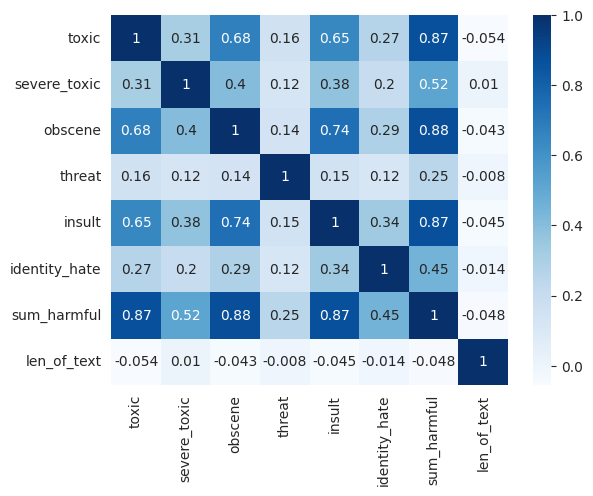

In [73]:
corr_matrix = train.corr()
sns.heatmap(corr_matrix, cmap='Blues',annot=True)
plt.show()

In [88]:
preprocess_text = train.preprocess_text

vectorizer = TfidfVectorizer(max_features=5000)

X = vectorizer.fit_transform(preprocess_text)
y = train[target_cols]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

print('X_train len: ', X_train.shape[0])
print('X_valid len:  ',  X_valid.shape[0])

X_train len:  127656
X_valid len:   31915


In [89]:
pre_test = test.preprocess_text
X_test = vectorizer.transform(pre_test)

In [92]:
accuracy_data = {}
for col in target_cols:
    print(' ')
    print('----prediction of {} column----'.format(col))
    print(' ')
    y = y_train[col]
    model = LogisticRegression()
    model.fit(X_train,y)
    y_pred = model.predict(X_valid)
    print('Testing accuracy is {}'.format(round(accuracy_score(y_valid[col], y_pred),5)))
    accuracy_data[col] = round(accuracy_score(y_valid[col], y_pred),5)
    test_y_prob = model.predict_proba(X_test)[:,1]
    submission[col] = test_y_prob

 
----prediction of toxic column----
 
Testing accuracy is 0.9572
 
----prediction of severe_toxic column----
 
Testing accuracy is 0.99007
 
----prediction of obscene column----
 
Testing accuracy is 0.97735
 
----prediction of threat column----
 
Testing accuracy is 0.99721
 
----prediction of insult column----
 
Testing accuracy is 0.97042
 
----prediction of identity_hate column----
 
Testing accuracy is 0.99204


In [103]:
# train set 전체 활용
submission_prediction = submission.copy()
preprocess_text = train.preprocess_text

vectorizer = TfidfVectorizer(max_features=5000)

X = vectorizer.fit_transform(preprocess_text)
y = train[target_cols]

for col in target_cols:
    print(' ')
    print('----prediction of {} column----'.format(col))
    y_train = y[col]
    model = LogisticRegression()
    model.fit(X,y_train)
    test_y_prob = model.predict_proba(X_test)[:,1]
    submission_prediction[col] = test_y_prob

 
----prediction of toxic column----
 
 
----prediction of severe_toxic column----
 
 
----prediction of obscene column----
 
 
----prediction of threat column----
 
 
----prediction of insult column----
 
 
----prediction of identity_hate column----
 


In [104]:
submission_prediction.to_csv(DATA_PATH+'submission.csv',index=False)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.998512,0.303343,0.997839,0.042393,0.956769,0.286966
1,0000247867823ef7,0.008974,0.002571,0.004679,0.001509,0.007192,0.002989
2,00013b17ad220c46,0.014559,0.001312,0.005219,0.000695,0.008768,0.001996
3,00017563c3f7919a,0.004318,0.002379,0.003936,0.000983,0.003446,0.000873
4,00017695ad8997eb,0.027386,0.001142,0.003783,0.000825,0.006146,0.001501
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.622014,0.003500,0.149602,0.002448,0.064477,0.007179
153160,fffd7a9a6eb32c16,0.076807,0.005451,0.029068,0.005278,0.038674,0.010341
153161,fffda9e8d6fafa9e,0.005296,0.001629,0.006473,0.000957,0.005004,0.001824
153162,fffe8f1340a79fc2,0.026087,0.002035,0.014881,0.002021,0.016446,0.012710
